# META Learner 소개 및 구현

## 1. 분석 배경 설정

##### 분석 시나리오
- 게임 앱 광고를 무작위 유저에게 노출
- 광고가 다운로드에 어떤 영향을 미쳤는지 추정하고자 함
- 실제 유저 데이터가 없으므로, causalml의 synthetic 데이터를 사용해 시뮬레이션 진행



##### 분석 지표 및 관점
- ITE(개별처치효과) : 개별 유저별로 “어떤 유저에게 광고를 재노출하면 효과가 클까?”(리타겟팅 우선순위)를 보고 싶음
    - 광고 예산이 제한되어 있을 때, ITE 예측치를 기준으로 우선순위 타게팅이 가능
- ATE(평균처치효과) : 전체 캠페인 효과(광고가 전체에 얼마나 영향을 주는가)가 궁금함
    - 전체 1000명 중 광고 노출이 평균적으로 얼마나 다운로드 확률을 높였는지 한눈에 파악 가능

## 2. Synthetic 데이터 생성

##### 데이터 구성 및 생성 방식
- 1000명의 유저 데이터를 생성
- 각 유저는 5개의 feature(X1~X5)를 가짐 -> ex- 나이, 일일 평균 앱 사용 시간(분)
- T (처치 여부): 광고 노출 여부 -> 이산형 처치
- Y (결과): 다운로드 여부
- tau: 개별 처치 효과 (ITE), 정답으로 활용

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalml.dataset import synthetic_data

# 2.1 데이터 생성
np.random.seed(42)
# mode=1: 개별 ITE(τ_true)가 포함된 합성 데이터 생성
# tau_true : true ITE (개별 처치효과; 정답)
# b, e     : 잠재 bias, noise 정보
Y, X, T, tau_true, b, e = synthetic_data(mode=1, n=1000, p=5)


# 2.2 DataFrame 정리
df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X.shape[1])])
df['T'] = T
df['Y'] = Y
df['tau_true'] = tau_true

print("=== Synthetic 데이터 ===")
print(df, "\n")

=== Synthetic 데이터 ===
           X1        X2        X3        X4        X5  T         Y  tau_true
0    0.374540  0.950714  0.731994  0.598658  0.156019  1  0.969019  0.662627
1    0.155995  0.058084  0.866176  0.601115  0.708073  0  1.671670  0.107039
2    0.020584  0.969910  0.832443  0.212339  0.181825  0  0.630293  0.495247
3    0.183405  0.304242  0.524756  0.431945  0.291229  0  1.589116  0.243823
4    0.611853  0.139494  0.292145  0.366362  0.456070  1  0.342692  0.375673
..        ...       ...       ...       ...       ... ..       ...       ...
995  0.446726  0.123450  0.205980  0.000943  0.039265  0 -0.007271  0.285088
996  0.977284  0.242354  0.663311  0.839100  0.550660  1  2.285836  0.609819
997  0.153145  0.728116  0.600251  0.731251  0.769747  1  1.647223  0.440630
998  0.975410  0.573563  0.341641  0.648465  0.068441  1  1.957809  0.774487
999  0.897397  0.119381  0.327843  0.815745  0.597312  0  1.292771  0.508389

[1000 rows x 8 columns] 



## 3. 메타러너 구현 (S-Learner, T-Learner)

게임 앱 광고가 유저별 다운로드 행동에 어떤 영향을 미쳤는지를 추정하기 위해, 인과 추론 기법 중 메타러너인 **S-learner**와 **T-learner**를 적용

In [91]:
from xgboost import XGBRegressor
from causalml.inference.meta import BaseSLearner, BaseTLearner

features  = X            # 독립변수: X1~X5 (유저의 특성)
treatment = T            # 처치 여부: 광고 노출 여부 (0 or 1)
outcome   = Y            # 결과 변수: 다운로드 여부

# 기본 회귀 모델 설정
# ▶ 비선형에 유용한 XGBoost를 base learner로 설정
base_learner = XGBRegressor(
    n_estimators=100,        # 트리 개수
    max_depth=3,             # 트리 깊이 제한
    learning_rate=0.1,       # 학습률
    random_state=42          
)

# S-러너, T-러너 객체 생성
# ▶ control_name=0: 광고 미노출 그룹을 기준으로 설정
s_learner = BaseSLearner(learner=base_learner, control_name=0)
t_learner = BaseTLearner(learner=base_learner, control_name=0)

# 모델 학습
# ▶ 전체 데이터(features, treatment, outcome)를 사용해 학습 진행
s_learner.fit(X=features, treatment=treatment, y=outcome)
t_learner.fit(X=features, treatment=treatment, y=outcome)

# ITE 예측
# ▶ 개별 유저별로 광고 노출 시 효과가 얼마나 있었는지 추정
ite_s = np.ravel(s_learner.predict(features))   # S-러너 기반 ITE
ite_t = np.ravel(t_learner.predict(features))   # T-러너 기반 ITE

## 4. 성능 평가

### 4-1-(1). ITE 성능 평가 지표 선정 및 시각화

실제 마케팅에서 중요한 "누구를 먼저 타겟할 것인가"에 초점을 맞춰 6장에서 학습한 아래 지표를 사용

- **누적 이득 곡선 (Gain Curve)**:  
  예측값을 기준으로 유저를 정렬했을 때, 상위 유저부터 얼마나 효과를 얻는지를 시각화

- **AUUC (Area Under the Uplift Curve)**:  
  누적 이득 곡선 아래 면적으로, **타겟 우선순위 모델의 효과 예측력을 정량화**

<Figure size 800x600 with 0 Axes>

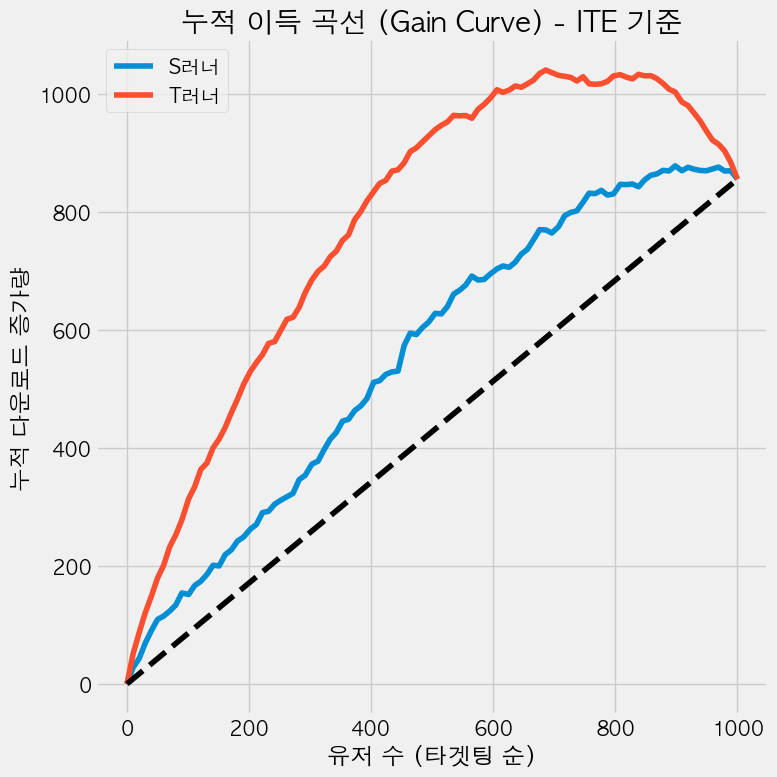

=== AUUC (모델별 누적 이득 곡선 면적) ===
S러너 → AUUC: 0.6477
T러너 → AUUC: 0.9097


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalml.metrics import plot_gain, auuc_score

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1) AUUC 계산
df_ite = pd.DataFrame({
    'y': outcome,
    'w': treatment,
    'S러너': ite_s,
    'T러너': ite_t
})

auuc = auuc_score(df_ite, outcome_col='y', treatment_col='w', normalize=True)

# 2) 누적 이득 곡선 시각화
plt.figure(figsize=(8,6))
plot_gain(df_ite, outcome_col='y', treatment_col='w', n=100)
plt.title('누적 이득 곡선 (Gain Curve) - ITE 기준')
plt.xlabel('유저 수 (타겟팅 순)')
plt.ylabel('누적 다운로드 증가량')
plt.legend(['S러너', 'T러너'])
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) AUUC 출력
print("=== AUUC (모델별 누적 이득 곡선 면적) ===")
print(f"S러너 → AUUC: {auuc['S러너']:.4f}")
print(f"T러너 → AUUC: {auuc['T러너']:.4f}")

### 4-1-(2) 결과 해석

1. 누적 이득 곡선
- X축: 타겟팅 우선순위에 따라 정렬된 유저 수 (상위 ITE 순)
- Y축: 누적 다운로드 증가량 (즉, 광고 노출로 인한 기대 효과 누적치)
- 파란 선 (S러너), 빨간 선 (T러너): 각 메타러너 모델이 예측한 ITE를 기준으로 타겟팅한 결과
- 검정 점선: 무작위 타겟팅 (Random Targeting) 기준선
- 해석 : T러너 곡선이 전체 구간에서 S러너보다 높고, 무작위 기준선보다도 우위에 있음 → T러너가 효과 높은 유저를 더 잘 선별한 것


2. AUUC
- AUUC는 누적 이득 곡선의 아래 면적을 의미
- 값이 클수록 타겟 우선순위 모델이 실제 uplift를 잘 반영한 것 (ex - 모델이 광고 타겟으로 가장 좋다고 판단한 상위 200명을 선정했더니, 기대 uplift 총합이 약 700점)

### 4-2-(1). ATE 성능 평가 지표 선정 및 시각화

전체 유저에게 광고 캠페인이 평균적으로 긍정적인 영향을 주었는지를 확인하고자, 다음 지표를 활용

- Bias (예측 편향):
모델이 추정한 평균 처치 효과(ATE)가 실제 효과에 비해 얼마나 차이 나는지를 측정
→ 예측 ATE가 과소/과대 평가되었는지를 파악 가능

예시:실제 ATE가 0.6인데 모델은 0.45라고 추정했다면, Bias는 -0.15로 평균적으로 효과를 낮게 본 모델이라는 의미

=== ATE 성능 요약 (편향 기준) ===
실제 ATE: 0.4982
S러너 → 예측 ATE: 0.4845, 편향(Bias): -0.0137
T러너 → 예측 ATE: 0.5528, 편향(Bias): 0.0546


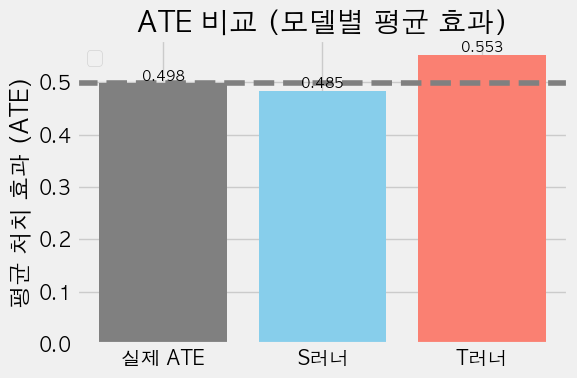

In [93]:
# 1) 실제 ATE와 모델별 ATE 계산
ate_true = np.mean(tau_true)     # 실제 평균 처치 효과
ate_s = np.mean(ite_s)           # S러너의 예측 ATE
ate_t = np.mean(ite_t)           # T러너의 예측 ATE

# 2) Bias 계산 (예측 ATE - 실제 ATE)
bias_s = ate_s - ate_true
bias_t = ate_t - ate_true

print("=== ATE 성능 요약 (편향 기준) ===")
print(f"실제 ATE: {ate_true:.4f}")
print(f"S러너 → 예측 ATE: {ate_s:.4f}, 편향(Bias): {bias_s:.4f}")
print(f"T러너 → 예측 ATE: {ate_t:.4f}, 편향(Bias): {bias_t:.4f}")

# 3) ATE 비교 막대그래프
labels = ['실제 ATE', 'S러너', 'T러너']
values = [ate_true, ate_s, ate_t]
colors = ['gray', 'skyblue', 'salmon']

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values, color=colors)
plt.title('ATE 비교 (모델별 평균 효과)')
plt.ylabel('평균 처치 효과 (ATE)')
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.005,
             f"{y:.3f}", ha='center', fontsize=10)
plt.axhline(ate_true, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

### 4-2-(2) 결과 해석

- S러너는 실제보다 보수적으로 예측하여 리스크 회피 전략에 적합
- T러너는 효과를 높게 보는 경향이 있어 공격적인 마케팅에 더 적합
- 예측 방향의 일관성과 편향을 함께 고려해 모델을 선택

### (번외) 추가 실험

<Figure size 1000x600 with 0 Axes>

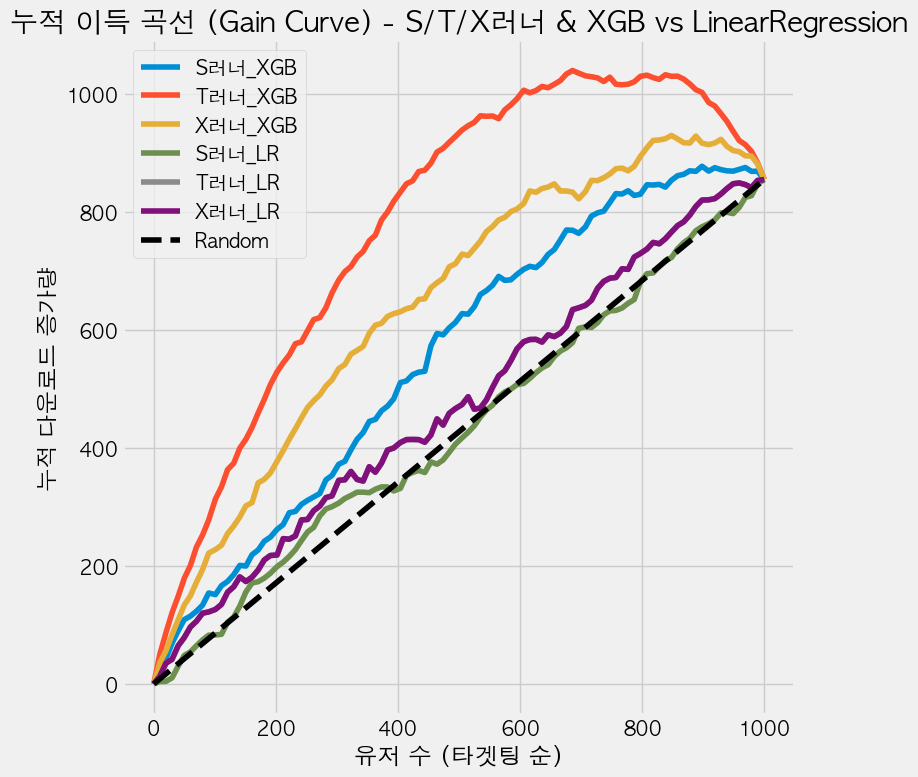

In [94]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner
from causalml.metrics import plot_gain, auuc_score
from causalml.dataset import synthetic_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

models = {
    "S러너_XGB": BaseSLearner(learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42), control_name=0),
    "T러너_XGB": BaseTLearner(learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42), control_name=0),
    "X러너_XGB": BaseXLearner(learner=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42), control_name=0),
    "S러너_LR": BaseSLearner(learner=LinearRegression(), control_name=0),
    "T러너_LR": BaseTLearner(learner=LinearRegression(), control_name=0),
    "X러너_LR": BaseXLearner(learner=LinearRegression(), control_name=0),
}

# 학습 + ITE 예측
df = pd.DataFrame({"y": Y, "w": T})
for name, model in models.items():
    model.fit(X=X, treatment=T, y=Y)
    df[name] = model.predict(X)

plt.figure(figsize=(10, 6))
plot_gain(df, outcome_col="y", treatment_col="w", n=100)
plt.title("누적 이득 곡선 (Gain Curve) - S/T/X러너 & XGB vs LinearRegression")
plt.xlabel("유저 수 (타겟팅 순)")
plt.ylabel("누적 다운로드 증가량")
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
df

,y,w,S러너_XGB,T러너_XGB,X러너_XGB,S러너_LR,T러너_LR,X러너_LR
0,0.969019,1,0.476462,-0.062333,0.194604,0.647318,0.574424,0.574424
1,1.671670,0,-0.100980,-0.908367,-0.614973,0.647318,0.056550,0.056550
2,0.630293,0,-0.019073,0.004851,0.135369,0.647318,0.306147,0.306147
3,1.589116,0,0.175211,0.223837,0.500003,0.647318,0.288157,0.288157
4,0.342692,1,0.475326,0.450082,0.598601,0.647318,0.681173,0.681173
...,...,...,...,...,...,...,...,...
995,-0.007271,0,0.509653,0.974690,0.884665,0.647318,0.565411,0.565411
996,2.285836,1,0.359546,0.637774,0.939812,0.647318,0.809996,0.809996
997,1.647223,1,0.115967,0.278803,0.005654,0.647318,0.438139,0.438139
998,1.957809,1,0.476461,0.105463,0.271305,0.647318,1.038483,1.038483


In [96]:
# 완전 일치는 안 함
(df['T러너_LR'] == df['X러너_LR']).all()

False

In [97]:
# 거의 비슷
np.allclose(df['T러너_LR'], df['X러너_LR'])

True

In [98]:
# https://github.com/uber/causalml/blob/master/docs/examples/meta_learners_with_synthetic_data.ipynb

#### LinearRegression 자체의 표현력 한계?
- X러너는 tau를 예측하는 모델인데, 이걸 LinearRegression으로 학습하면 비선형 구조를 제대로 반영 못함
- 즉, X러너가 잘 작동하려면 표현력이 높은 base learner가 필요함. T러너와 X러너 모두 결국 같은 선형식을 학습하게 되므로 차이가 거의 없음
- 결국 학습 대상만 다르고, 선형 모델이 같아서 비슷한 함수에 수렴

#### X러너는 "control과 treatment 간 분포 차이"가 클수록 유리
- 하지만 synthetic data가 그렇게까지 큰 분포 차이를 만들어내지 않으면, mu0(x), mu1(x) 자체가 거의 비슷한 영역에서 추정되기 때문에 X러너의 의미 있는 weight 보정 효과가 작동하지 않을 가능성